## Import Libraries
___
___

In [1]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
import cv2

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.1


## Loading and displaying the data
___
___

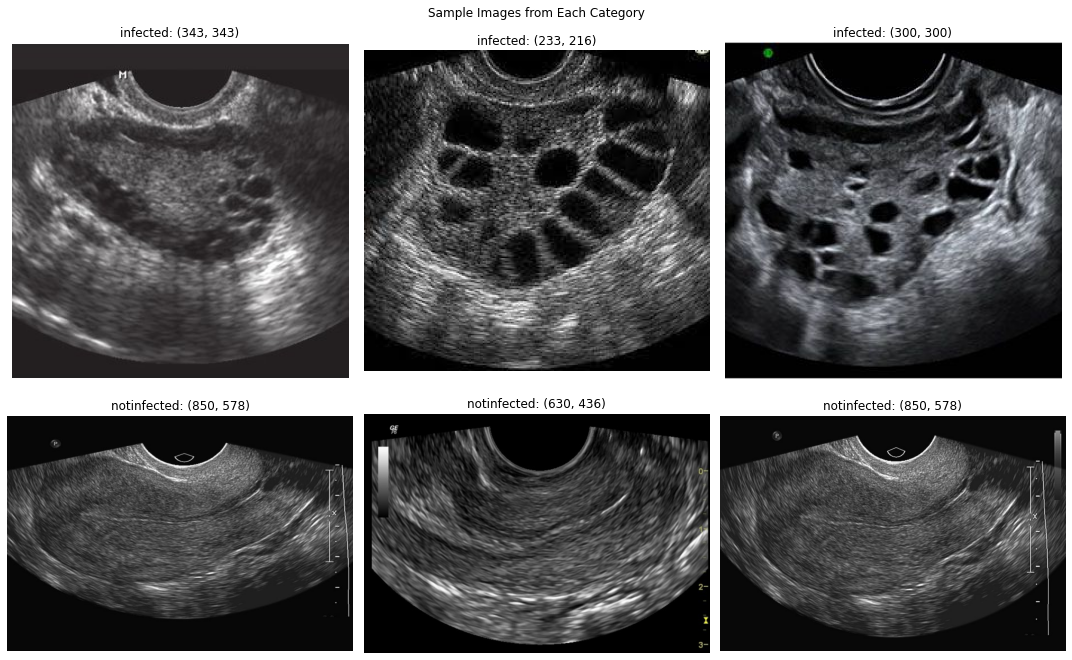

In [3]:
# Set the path to your dataset
data_dir = 'C:/Users/DELL/Desktop/Res_project/PCOS/PCOS/data/train'

# Categories
categories = ['infected', 'notinfected']

# Setup the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Sample Images from Each Category')

for i, category in enumerate(categories):
    # Get the directory for each category
    category_dir = os.path.join(data_dir, category)
    # List a few images
    sample_images = os.listdir(category_dir)[:3] 

    for j, image_file in enumerate(sample_images):
        # Load the image
        img_path = os.path.join(category_dir, image_file)
        img = Image.open(img_path)
        # Display the image
        ax = axes[i, j]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"{category}: {img.size}")

plt.tight_layout()
plt.show()

## Preprocessing Data
___
___

Found 1348 images belonging to 2 classes.
Found 576 images belonging to 2 classes.
Found 1924 files belonging to 2 classes.


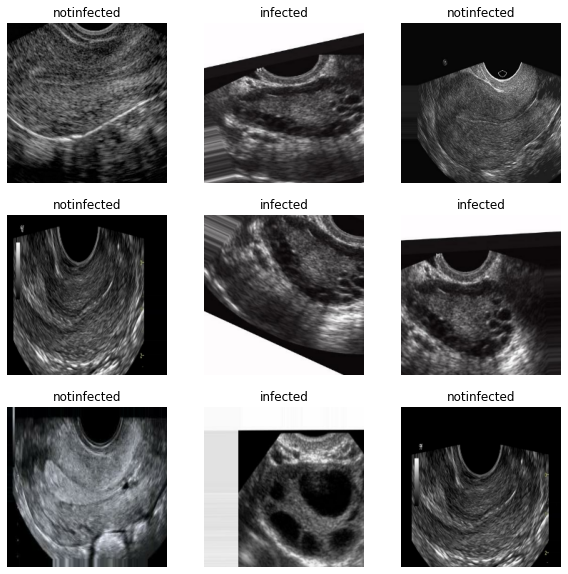

Batch shape=(100, 2), min=0.000, max=1.000
Batch shape=(100, 224, 224, 3), min=0.000, max=1.000


In [4]:
# Define the path to your training data
directory = 'C:/Users/DELL/Desktop/Res_project/PCOS/PCOS/data/train'

# Create the ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    validation_split=0.3,  # Use 30% of the data for validation
    fill_mode='nearest'
)

# Create iterators for training and validation
train_it = train_datagen.flow_from_directory(
    directory,
    class_mode='categorical',
    classes=['infected', 'notinfected'],
    target_size=(224, 224),
    batch_size=100,  
    subset='training',  
    seed=24
)

val_it = train_datagen.flow_from_directory(
    directory,
    class_mode='categorical',
    classes=['infected', 'notinfected'],
    target_size=(224, 224),
    batch_size=100,  
    subset='validation',  
    seed=24
)

# Load data 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names=['infected', 'notinfected'],
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=24,
    interpolation="bilinear",
    follow_links=True
)

# Display images
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

# Get one batch of training data
iterator=iter(train_it)
batchX, batchy = next(iterator)
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchy.shape, batchy.min(), batchy.max()))
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

In [5]:
# Define the path and generator for the validation data
val_directory = 'C:/Users/DELL/Desktop/Res_project/PCOS/PCOS/data/test'
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

Found 1922 images belonging to 2 classes.


# CONVOLUTIONAL NEURAL NETWORK (CNN)
___
___

## Constructing the CNN Model
___
___

In [6]:
# Define the CNN model architecture
model = Sequential([
    Conv2D(12, (6, 6), padding='valid', activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(6, 6)),
    Conv2D(15, (5, 5), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(5, 5)),
    Conv2D(10, (3, 3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 219, 219, 12)      1308      
                                                                 
 max_pooling2d (MaxPooling2  (None, 36, 36, 12)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 15)        4515      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 15)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 10)          1360      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 10)        

## Training the Model
___
___

In [7]:
# Train the model
history = model.fit(
    train_it,
    validation_data=val_it,
    epochs=8  
)

model.save('C:/Users/DELL/Desktop/Res_project/PCOS/PCOS/models/cnn_model2.h5')

Epoch 1/8


14/14 [==============================] - 63s 4s/step - loss: 0.6769 - accuracy: 0.5942 - val_loss: 0.6562 - val_accuracy: 0.5938
Epoch 2/8
14/14 [==============================] - 47s 3s/step - loss: 0.6343 - accuracy: 0.6061 - val_loss: 0.5872 - val_accuracy: 0.7396
Epoch 3/8
14/14 [==============================] - 64s 5s/step - loss: 0.4966 - accuracy: 0.8405 - val_loss: 0.3772 - val_accuracy: 0.8628
Epoch 4/8
14/14 [==============================] - 57s 4s/step - loss: 0.2626 - accuracy: 0.9451 - val_loss: 0.1626 - val_accuracy: 0.9653
Epoch 5/8
14/14 [==============================] - 51s 4s/step - loss: 0.1218 - accuracy: 0.9711 - val_loss: 0.0836 - val_accuracy: 0.9861
Epoch 6/8
14/14 [==============================] - 52s 4s/step - loss: 0.0806 - accuracy: 0.9770 - val_loss: 0.0613 - val_accuracy: 0.9896
Epoch 7/8
14/14 [==============================] - 52s 4s/step - loss: 0.0572 - accuracy: 0.9852 - val_loss: 0.0377 - val_accuracy: 0.9948
Epoch 8/8
14/14 [========

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Validation and Performance Metrics
___
___

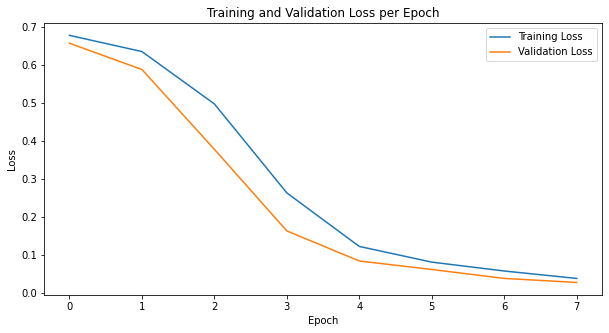

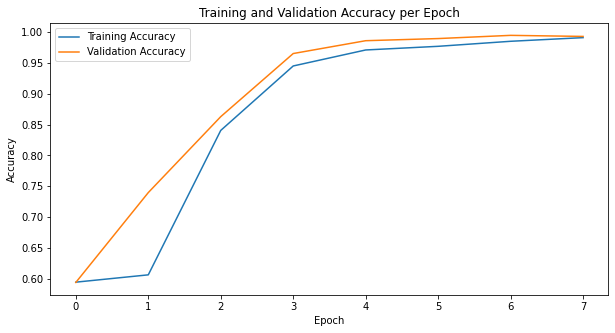

In [8]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

61/61 [==============================] - 17s 269ms/step


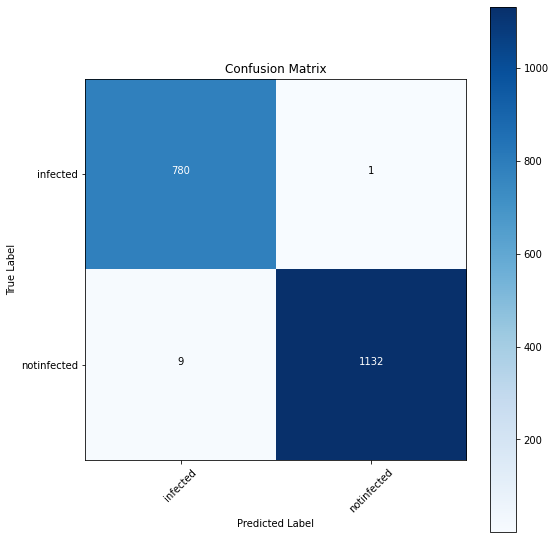

In [9]:

# Calculate the number of validation steps per epoch
val_steps_per_epoch = np.ceil(val_generator.samples / val_generator.batch_size)
val_steps_per_epoch = int(val_steps_per_epoch)  # Convert to integer
# Get predictions
predictions = model.predict(val_generator, steps=val_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()

In [10]:
import numpy as np
from sklearn.metrics import classification_report
from tabulate import tabulate

# Assuming true_classes and predicted_classes are defined from your model predictions
class_labels = ['Infected', 'Not Infected']  

# Generate the classification report
cr = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Convert the classification report dictionary into a table using tabulate
table = []
for key, value in cr.items():
    if isinstance(value, dict):  
        row = [key]
        row.extend([f"{value['precision']:.2f}", f"{value['recall']:.2f}", f"{value['f1-score']:.2f}", f"{value['support']}"])
        table.append(row)

# Add summary statistics
overall = cr['accuracy']
weighted_avg = cr['weighted avg']
table.append(["", "", "", "", ""])
table.append(["Accuracy", "", "", f"{overall:.2f}", ""])
table.append(["Weighted Avg", f"{weighted_avg['precision']:.2f}", f"{weighted_avg['recall']:.2f}", f"{weighted_avg['f1-score']:.2f}", f"{weighted_avg['support']}"])

# Define headers and print the table
headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
print(tabulate(table, headers=headers, tablefmt="grid"))


+--------------+-------------+----------+------------+-----------+
| Class        | Precision   | Recall   | F1-Score   | Support   |
+==============+=============+==========+============+===========+
| Infected     | 0.99        | 1.00     | 0.99       | 781       |
+--------------+-------------+----------+------------+-----------+
| Not Infected | 1.00        | 0.99     | 1.00       | 1141      |
+--------------+-------------+----------+------------+-----------+
| macro avg    | 0.99        | 1.00     | 0.99       | 1922      |
+--------------+-------------+----------+------------+-----------+
| weighted avg | 0.99        | 0.99     | 0.99       | 1922      |
+--------------+-------------+----------+------------+-----------+
|              |             |          |            |           |
+--------------+-------------+----------+------------+-----------+
| Accuracy     |             |          | 0.99       |           |
+--------------+-------------+----------+------------+--------

## Testing
___
___

In [11]:
# Load the pre-trained model
model = keras.models.load_model('C:/Users/DELL/Desktop/Res_project/PCOS/PCOS/models/cnn_model2.h5')

# Load and preprocess the image
image_path = 'C:/Users/DELL/Desktop/Res_project/PCOS/PCOS/data/test/infected/img_0_9949.jpg'
image = load_img(image_path, target_size=(224, 224))
img = img_to_array(image)  # Convert image to numpy array
img = img / 255.0  # Normalizing the image to the [0, 1] range
img = np.expand_dims(img, axis=0)  # Reshape image to match model's input shape (add batch dimension)

# Predict the class of the image
prediction = model.predict(img)

# Print the raw prediction output
print("Raw prediction output:", prediction)

1/1 [==============================] - 0s 228ms/step
Raw prediction output: [[9.9999964e-01 3.8673164e-07]]


Predicted Class: Infected


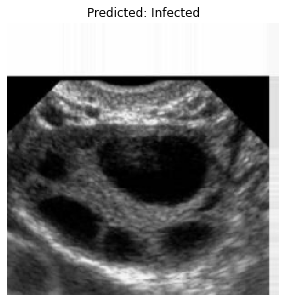

In [12]:
# Convert predictions to a dictionary with class labels
prediction_dict = {"Infected": prediction[0][0], "Not-Infected": prediction[0][1]}

# Define a function to return the class label based on the highest probability
def get_key(max_value):
    for key, value in prediction_dict.items():
        if value == max_value:
            return key
    return "key doesn't exist"

# Find the class label with the maximum probability
max_prob = prediction.max()
predicted_class = get_key(max_prob)
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.figure(figsize=(5, 5))
plt.imshow(image)  
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')  
plt.show()

1/1 [==============================] - 0s 220ms/step
Prediction: Infected


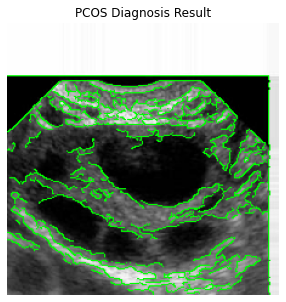

In [13]:
# Load the pre-trained model
model = load_model('C:/Users/DELL/Desktop/Res_project/PCOS/PCOS/models/cnn_model2.h5')

# Function to process an image and prepare it for model input
def process_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalize to 0-1 range
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img  # Return img as a PIL image

# Function to apply Canny edge detection to highlight edges
def highlight_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Blurring to reduce noise
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)  # Fine-tune these thresholds
    # Overlay edges on the original image
    img[edges == 255] = [0, 255, 0]  # Highlighting in green
    return img

# Predict the class and overlay the result
def predict_and_visualize(img_path):
    img_array, pil_img = process_image(img_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    class_labels = {0: 'Infected', 1: 'Not Infected'}
    
    # Convert PIL image to a format that OpenCV can handle
    img = np.array(pil_img)
    img = img.astype('uint8')

    # Apply Canny edge detection if predicted as Infected
    if predicted_class == 0:
        img = highlight_edges(img)
    
    # Print prediction in the console
    print(f"Prediction: {class_labels[predicted_class]}")
    return img

# Path to your image
img_path = 'C:/Users/DELL/Desktop/Res_project/PCOS/PCOS/data/test/infected/img_0_9949.jpg'  

# Process image, predict, and visualize
result_img = predict_and_visualize(img_path)

# Display the result using matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct coloring
plt.title("PCOS Diagnosis Result")
plt.axis('off')  # Hide axes
plt.show()
